<a href="https://colab.research.google.com/github/amfolity/interpretability/blob/main/SoftmaxProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def adaptive_temperature_softmax(logits):
  original_probs = jax.nn.softmax(logits)
  poly_fit = jnp.array([-0.037, 0.481, -2.3, 4.917, -1.791]) # see Figure 5
  entropy = jnp.sum(-original_probs * jnp.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
  beta = jnp.where( # beta = 1 / theta
                   entropy > 0.5, # don’t overcorrect low-entropy heads
  jnp.maximum(jnp.polyval(poly_fit, entropy), 1.0), # never increase entropy
  1.0)
return jax.nn.softmax(logits * beta)

hi


In [ ]:
import transformers

In [ ]:
model_name = 'google/gemma-2-2b-it'


In [ ]:
from huggingface_hub import login
login()

In [ ]:
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
model = transformers.AutoModelForCausalLM.from_pretrained(model_name)

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

In [ ]:
for param in model.parameters():
  param.requires_grad = False

In [ ]:
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

In [ ]:
import torch
prompt = ''

In [ ]:
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False)
for i in range(10):
  next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
  batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
  batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print(tokenizer.decode(batch['input_ids'][0]))

NameError: name 'tokenizer' is not defined

In [ ]:
batch

{'input_ids': tensor([[     2, 235280,   4320,   8426,  25341]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import jax.numpy as jnp
from flax import linen as nn
from typing import Callable
class Model(nn.Module):
  def __init__(self, n_classes, n_feats, activation):
    super().__init__()
  n_classes = n_classes # 10
  n_feats = n_feats # 128
  activation = nn.gelu


def __call__(self, x, q):
  x = nn.Dense(features=self.n_feats)(x)
  x = self.activation(x)
  x = nn.Dense(features=self.n_feats)(x)
  x = self.activation(x)
  q = nn.Dense(features=self.n_feats)(q)
  q = self.activation(q)
  q = nn.Dense(features=self.n_feats)(q)
  x = nn.MultiHeadDotProductAttention(
  num_heads=1,
  qkv_features=self.n_feats)(
  inputs_q=q,
  inputs_kv=x)
  x = nn.Dense(features=self.n_feats)(jnp.squeeze(x, -2))
  x = self.activation(x)
  x = nn.Dense(features=self.n_classes)(x)
  return x

In [13]:
import functools

def f(a,b=4):
  '''
  ya krivedko
  '''
  return a*10 + b

ff = functools.partial(f, b=5)

ff(a=7)

25

In [36]:
from copy import deepcopy
import math
weights_log = []

# Efficient implementation equivalent to the following:
def custom_scaled_dot_product_attention(query, key, value, attn_mask=None, dropout_p=0.0,
        is_causal=False, scale=None, enable_gqa=False, logging=False, softmax = torch.softmax) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    if logging:
      weights_log.append(attn_weight.detach().cpu().numpy())
    return attn_weight @ value

In [68]:
import torch
class Model(nn.Module):
  def __init__(self, n_classes=10, n_feats=128, activation=nn.GELU()):
    super().__init__()
    self.n_classes = n_classes
    self.n_feats = n_feats
    self.activation = activation
    self.fc1 = nn.Linear(in_features=self.n_classes + 1, out_features=self.n_feats)
    self.fc2 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc3 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc4 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.q_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)
    self.k_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)
    self.v_proj = nn.Linear(in_features=self.n_feats, out_features=self.n_feats, bias=False)

    self.fc5 = nn.Linear(in_features=self.n_feats, out_features=self.n_feats)
    self.fc6 = nn.Linear(in_features=self.n_feats, out_features=self.n_classes)
    self.attention_function = F.scaled_dot_product_attention


  def forward(self, x, q):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
    q = self.activation(self.fc3(q))
    q = self.fc4(q)
    k = self.k_proj(x)
    q = self.q_proj(q)
    v = self.v_proj(x)

    #print(q.shape)
    ##print(x.unsqueeze(-3).shape)
    #print(x.shape)

    x = self.attention_function(q.unsqueeze(-3), k.unsqueeze(-3), v.unsqueeze(-3), is_causal=False)

    #print(x.shape)
    #print(x.squeeze(-2).squeeze(-2).shape)

    x = self.fc6(self.activation(self.fc5(x.squeeze(-2).squeeze(-2))))

    #print(x.shape)
    return x

In [69]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float32 if device=='cuda' else torch.float32

In [70]:
batch_size = 128  # Number of samples in the batch
input_dim = 128   # Number of features per sample
n = 16
num_classes = 10
# Generate a batch of random values in the range [0,1)

rho = torch.rand(batch_size, n, 1)
cla = torch.randint(0, num_classes, (batch_size, n))
one_hot = torch.zeros(batch_size, n, num_classes)
one_hot.scatter_(2, cla.unsqueeze(2), 1)
X = torch.cat([rho, one_hot], dim=-1)
Y = cla.take(torch.argmax(rho.squeeze(-1), dim=-1))
q = torch.rand(batch_size, 1, input_dim)



#q =  torch.rand(1, input_dim)
model = Model(n_classes=num_classes, n_feats=input_dim, activation=nn.GELU())
#model(X,q)

In [40]:
model.attention_function = functools.partial(custom_scaled_dot_product_attention, logging=False, softmax=torch.softmax)

In [71]:
model.to(device).to(dtype)

Model(
  (activation): GELU(approximate='none')
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (q_proj): Linear(in_features=128, out_features=128, bias=False)
  (k_proj): Linear(in_features=128, out_features=128, bias=False)
  (v_proj): Linear(in_features=128, out_features=128, bias=False)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=10, bias=True)
)

In [72]:
model.fc3.weight

Parameter containing:
tensor([[ 0.0232,  0.0017, -0.0582,  ...,  0.0017, -0.0802, -0.0165],
        [-0.0510,  0.0574, -0.0316,  ...,  0.0881,  0.0716,  0.0637],
        [ 0.0192,  0.0406, -0.0631,  ..., -0.0495, -0.0824, -0.0275],
        ...,
        [-0.0088,  0.0621,  0.0653,  ..., -0.0245, -0.0451,  0.0220],
        [-0.0133,  0.0093,  0.0845,  ...,  0.0738, -0.0552, -0.0323],
        [ 0.0287,  0.0710,  0.0763,  ...,  0.0627, -0.0558, -0.0684]],
       device='cuda:0', requires_grad=True)

In [73]:
model.fc3.weight

Parameter containing:
tensor([[ 0.0232,  0.0017, -0.0582,  ...,  0.0017, -0.0802, -0.0165],
        [-0.0510,  0.0574, -0.0316,  ...,  0.0881,  0.0716,  0.0637],
        [ 0.0192,  0.0406, -0.0631,  ..., -0.0495, -0.0824, -0.0275],
        ...,
        [-0.0088,  0.0621,  0.0653,  ..., -0.0245, -0.0451,  0.0220],
        [-0.0133,  0.0093,  0.0845,  ...,  0.0738, -0.0552, -0.0323],
        [ 0.0287,  0.0710,  0.0763,  ...,  0.0627, -0.0558, -0.0684]],
       device='cuda:0', requires_grad=True)

In [74]:
torch.max(model.fc3.weight)

tensor(0.0884, device='cuda:0', grad_fn=<MaxBackward1>)

In [75]:
import random
import tqdm
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0003)
#opt = torch.optim.Adam(model.parameters(), lr=0.01)
q = torch.rand(1, 1, input_dim, device=device, dtype=dtype).tile((batch_size, 1, 1))


for epoch in tqdm.trange(100000):
  n = random.randint(5, 16)
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  rhomax = torch.max(rho, dim = -2, keepdims=True)
  rho[rho != rhomax] *= 0.8

  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  opt.zero_grad()
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  if epoch % 1000 == 0:
    print("loss is {}".format(loss.item()))
  loss.backward()
  opt.step()

  0%|          | 47/100000 [00:00<07:11, 231.74it/s]

loss is 2.3040032386779785


  1%|          | 1052/100000 [00:03<05:55, 278.49it/s]

loss is 0.026722384616732597


  2%|▏         | 2045/100000 [00:08<05:44, 284.28it/s]

loss is 0.16396412253379822


  3%|▎         | 3034/100000 [00:12<06:08, 262.96it/s]

loss is 0.07464362680912018


  4%|▍         | 4033/100000 [00:16<06:11, 258.32it/s]

loss is 0.04169485345482826


  5%|▌         | 5029/100000 [00:20<06:55, 228.69it/s]

loss is 0.14404745399951935


  6%|▌         | 6053/100000 [00:24<05:42, 274.45it/s]

loss is 0.02741512469947338


  7%|▋         | 7057/100000 [00:28<05:35, 276.88it/s]

loss is 0.1099008172750473


  8%|▊         | 8037/100000 [00:32<06:09, 248.84it/s]

loss is 0.01863056607544422


  9%|▉         | 9030/100000 [00:36<05:35, 271.53it/s]

loss is 0.01346536073833704


 10%|█         | 10055/100000 [00:39<05:24, 277.32it/s]

loss is 0.03308599814772606


 11%|█         | 11025/100000 [00:44<07:44, 191.65it/s]

loss is 0.025109225884079933


 12%|█▏        | 12039/100000 [00:48<05:42, 257.09it/s]

loss is 0.012791893444955349


 13%|█▎        | 13028/100000 [00:51<05:10, 279.66it/s]

loss is 0.09734489023685455


 14%|█▍        | 14036/100000 [00:55<06:41, 214.14it/s]

loss is 0.013592880219221115


 15%|█▌        | 15026/100000 [00:59<05:16, 268.52it/s]

loss is 0.06736710667610168


 16%|█▌        | 16051/100000 [01:03<05:19, 262.93it/s]

loss is 0.020556015893816948


 17%|█▋        | 17031/100000 [01:07<06:26, 214.75it/s]

loss is 0.0025257307570427656


 18%|█▊        | 18050/100000 [01:11<04:49, 282.79it/s]

loss is 0.0928342416882515


 19%|█▉        | 19044/100000 [01:15<04:53, 275.37it/s]

loss is 0.019167838618159294


 20%|██        | 20045/100000 [01:19<04:48, 277.14it/s]

loss is 0.04218089208006859


 21%|██        | 21055/100000 [01:23<04:41, 280.79it/s]

loss is 0.04009205847978592


 22%|██▏       | 22054/100000 [01:26<04:40, 278.34it/s]

loss is 0.015759963542222977


 23%|██▎       | 23036/100000 [01:30<04:38, 276.73it/s]

loss is 0.10242417454719543


 24%|██▍       | 24056/100000 [01:35<04:29, 281.64it/s]

loss is 0.020774392411112785


 25%|██▌       | 25050/100000 [01:38<04:34, 272.78it/s]

loss is 0.030318262055516243


 26%|██▌       | 26042/100000 [01:42<04:35, 268.12it/s]

loss is 0.054470494389534


 27%|██▋       | 27051/100000 [01:46<04:31, 268.86it/s]

loss is 0.03724126145243645


 28%|██▊       | 28051/100000 [01:50<04:25, 270.94it/s]

loss is 0.007341216783970594


 29%|██▉       | 29021/100000 [01:54<04:27, 265.27it/s]

loss is 0.006870592013001442


 30%|███       | 30033/100000 [01:58<05:11, 224.55it/s]

loss is 0.029941780492663383


 31%|███       | 31030/100000 [02:02<04:35, 250.68it/s]

loss is 0.010363881476223469


 32%|███▏      | 32042/100000 [02:05<04:08, 274.00it/s]

loss is 0.03156180679798126


 33%|███▎      | 33032/100000 [02:10<05:28, 203.67it/s]

loss is 0.00816264282912016


 34%|███▍      | 34036/100000 [02:14<03:56, 278.82it/s]

loss is 0.0036750114522874355


 35%|███▌      | 35021/100000 [02:17<04:26, 244.22it/s]

loss is 0.201216459274292


 36%|███▌      | 36030/100000 [02:22<06:22, 167.36it/s]

loss is 0.02288583666086197


 37%|███▋      | 37033/100000 [02:26<03:46, 278.07it/s]

loss is 0.01941550523042679


 38%|███▊      | 38045/100000 [02:29<03:44, 275.59it/s]

loss is 0.06129998713731766


 39%|███▉      | 39038/100000 [02:33<04:55, 206.07it/s]

loss is 0.012368381023406982


 40%|████      | 40057/100000 [02:38<03:35, 278.47it/s]

loss is 0.02865704521536827


 41%|████      | 41028/100000 [02:41<04:23, 223.80it/s]

loss is 0.016408680006861687


 42%|████▏     | 42037/100000 [02:45<04:29, 214.72it/s]

loss is 0.0314597561955452


 43%|████▎     | 43030/100000 [02:49<03:32, 268.56it/s]

loss is 0.07338851690292358


 44%|████▍     | 44037/100000 [02:53<03:29, 267.17it/s]

loss is 0.02956335060298443


 45%|████▌     | 45042/100000 [02:57<03:17, 277.89it/s]

loss is 0.020198823884129524


 46%|████▌     | 46054/100000 [03:01<03:13, 278.47it/s]

loss is 0.0068661849945783615


 47%|████▋     | 46627/100000 [03:03<03:30, 253.70it/s]


KeyboardInterrupt: 

In [105]:
weights_log = []
max_rho_idcs = []
model.attention_function = functools.partial(custom_scaled_dot_product_attention, logging=True, softmax=torch.softmax)

In [106]:
for pw2 in range(4, 15, 1):
  n = 1 << pw2
  rho = torch.rand(batch_size, n, 1, device=device, dtype=dtype)
  idcs = torch.argsort(rho.squeeze(-1), dim=-1)[:, -16:]
  max_rho_idcs.append(idcs.cpu().numpy())

  cla = torch.randint(0, num_classes, (batch_size, n), device=device)
  one_hot = torch.zeros(batch_size, n, num_classes, device=device, dtype=dtype)
  one_hot.scatter_(2, cla.unsqueeze(2), 1)
  X = torch.cat([rho, one_hot], dim=-1)
  Y = cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)
  #q = torch.rand(batch_size, 1, input_dim, device=device, dtype=dtype)
  outputs = model(X,q) ## what is X and q here, do we need to generate each tim
  loss = F.cross_entropy(outputs, Y)
  print("loss is {}".format(loss.item()))


loss is 0.0012580248294398189
loss is 0.10828951746225357
loss is 0.11143272370100021
loss is 0.2472699135541916
loss is 0.4428033232688904
loss is 1.3125340938568115
loss is 1.7421679496765137
loss is 2.305121421813965
loss is 2.80720853805542
loss is 2.8998334407806396
loss is 2.9089534282684326


In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

In [108]:
len(weights_log)

11

In [115]:
weights_log[0].squeeze().take(max_rho_idcs[0])

(128, 16)

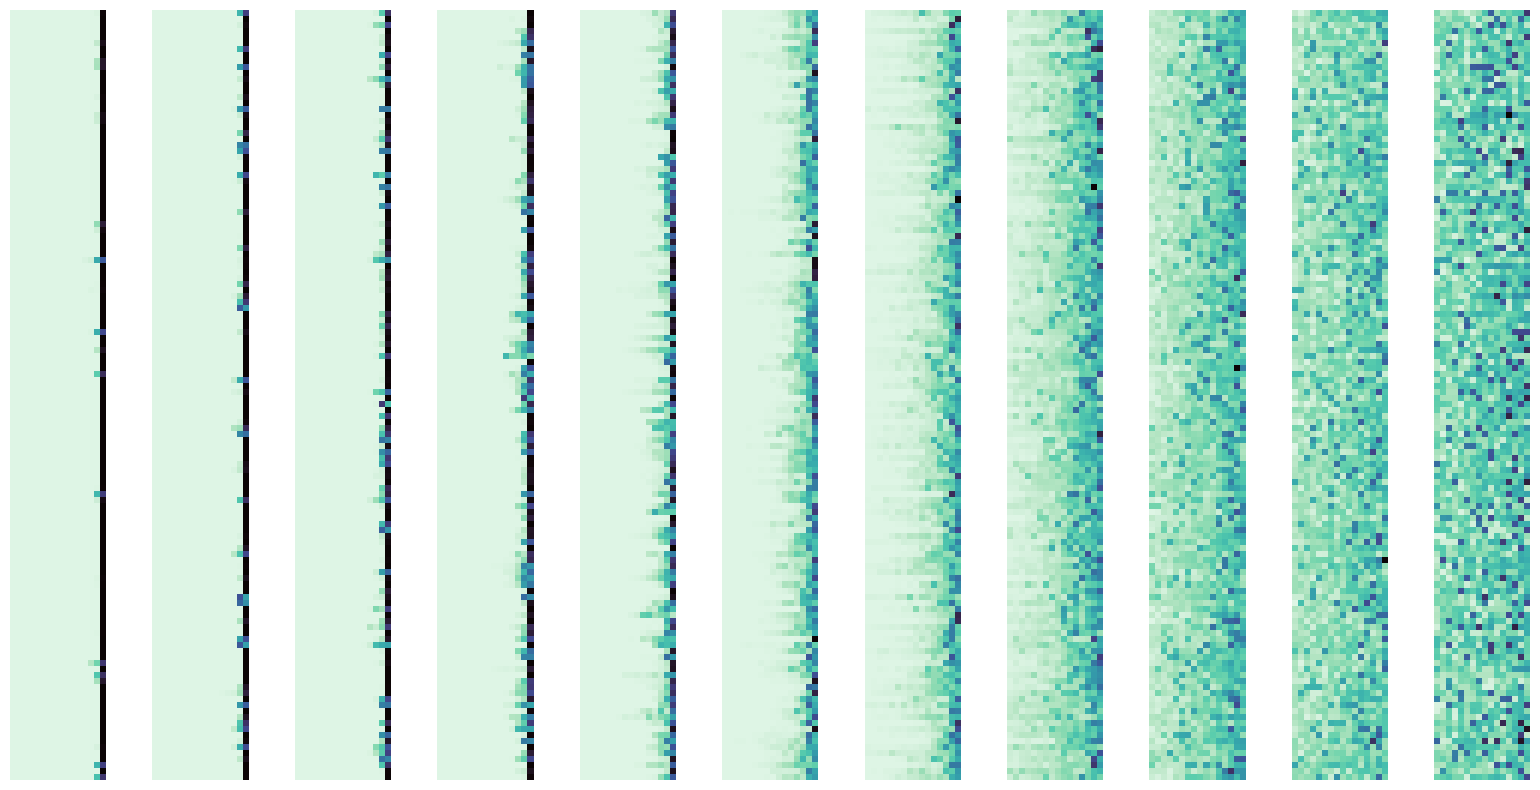

In [118]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(1, 11, figsize=(16, 8))

# Plot each heatmap
for i, ax in enumerate(axes.flat):
    data = weights_log[i].squeeze()
    #np.sort(data)
    #data = np.sort(data)[:, -16:]
    data = np.take_along_axis(data, max_rho_idcs[i], -1)
    sns.heatmap(-data, ax=ax, cbar=False, square=True, cmap='mako')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [60]:
idx = 101
print(X[idx])
print(Y[idx])

tensor([[0.6077, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.4161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 1.0000],
        [0.7344, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.8621, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7682, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000],
        [0.7123, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         1.0000, 0.0000],
        [0.0200, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000],
        [0.5742, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000]], device='cuda:0')
tensor(1, device='cuda:0')


In [26]:
print(rho[idx])
print(cla[idx])

tensor([[0.5275],
        [0.1077],
        [0.9811],
        [0.0509],
        [0.9447],
        [0.3840],
        [0.1458],
        [0.2467]], device='cuda:0')
tensor([0, 3, 0, 4, 4, 4, 1, 6], device='cuda:0')


In [29]:
rho.shape

torch.Size([128, 8, 1])

In [40]:
torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1)

tensor([[2],
        [2],
        [2],
        [2],
        [0],
        [0],
        [0],
        [4],
        [4],
        [5],
        [6],
        [2],
        [7],
        [0],
        [5],
        [3],
        [3],
        [3],
        [4],
        [4],
        [2],
        [5],
        [5],
        [4],
        [5],
        [4],
        [1],
        [1],
        [0],
        [4],
        [0],
        [5],
        [7],
        [7],
        [7],
        [6],
        [6],
        [5],
        [1],
        [5],
        [3],
        [4],
        [7],
        [5],
        [2],
        [0],
        [1],
        [4],
        [2],
        [3],
        [0],
        [3],
        [2],
        [5],
        [1],
        [2],
        [5],
        [6],
        [7],
        [7],
        [3],
        [0],
        [7],
        [4],
        [2],
        [6],
        [6],
        [5],
        [3],
        [3],
        [6],
        [1],
        [0],
        [5],
        [7],
        [0],
        [7],

In [46]:
cla.take_along_dim(torch.argmax(rho.squeeze(-1), dim=-1).unsqueeze(-1), dim=-1).squeeze(-1)

tensor([6, 8, 4, 0, 6, 1, 6, 9, 2, 7, 1, 3, 8, 0, 2, 0, 4, 6, 1, 7, 8, 0, 1, 2,
        3, 9, 8, 7, 0, 9, 4, 0, 0, 5, 3, 1, 5, 5, 6, 1, 9, 1, 2, 3, 9, 9, 5, 7,
        1, 8, 4, 2, 1, 9, 6, 4, 3, 8, 6, 2, 0, 8, 6, 1, 6, 5, 3, 4, 2, 7, 3, 2,
        0, 0, 6, 6, 4, 0, 4, 8, 6, 9, 3, 0, 8, 4, 5, 7, 9, 0, 2, 5, 3, 7, 7, 8,
        0, 3, 3, 5, 4, 9, 9, 8, 5, 9, 8, 4, 8, 7, 5, 3, 7, 4, 4, 9, 0, 1, 6, 4,
        4, 8, 0, 0, 8, 9, 0, 6], device='cuda:0')

In [ ]:
model(X,q)[6]

torch.Size([128, 1, 128])
torch.Size([128, 1, 7, 128])
torch.Size([128, 7, 128])
torch.Size([128, 1, 1, 128])
torch.Size([128, 128])
torch.Size([128, 10])


tensor([ 0.0326,  0.1267,  0.0637,  0.0893,  0.0409, -0.1043,  0.0812, -0.0475,
        -0.0947,  0.0971], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
cla[0]

tensor([6, 7, 1, 0, 6, 8, 9, 0, 0, 4, 5, 0, 5, 3, 1, 8], device='cuda:0')

In [ ]:
torch.argmax(rho.squeeze(-1), dim=-1)

tensor([ 8,  3, 14,  6, 11, 10, 15,  4,  8, 10, 12,  1,  9,  0, 11, 13,  2,  9,
         6, 11,  9, 11,  2, 13, 15,  0,  9,  4,  1, 11, 10,  3,  4,  7,  4, 10,
        10, 13,  2,  8,  6,  4,  0,  9,  4, 12,  4,  2,  8,  0, 15,  3,  0,  1,
        15,  5,  9, 11,  1,  3,  2,  0,  3,  7])

In [ ]:
cla.take(torch.argmax(rho.squeeze(-1), dim=-1))

tensor([5, 2, 4, 0, 5, 5, 7, 8, 5, 5, 8, 5, 5, 2, 5, 6, 5, 5, 0, 5, 5, 5, 5, 6,
        7, 2, 5, 8, 5, 5, 5, 2, 8, 6, 8, 5, 5, 6, 5, 5, 0, 8, 2, 5, 8, 8, 8, 5,
        5, 2, 7, 2, 2, 5, 7, 4, 5, 5, 5, 2, 5, 2, 2, 6])

In [ ]:
outputs = model(batch, q)

AttributeError: module 'torch.nn' has no attribute 'MultiHeadDotProductAttention'

In [ ]:
outputs = model(**batch)
next_word_logits = outputs.logits[:, num_prompts : -1, :]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

TypeError: Model(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=10, out_features=10, bias=True)
) argument after ** must be a mapping, not Tensor

In [ ]:
while loss.item() > 0.1:
  model.zero_grad()
  opt.zero_grad()
  outputs = model(**batch)
  next_word_logits = outputs.logits[:, num_prompts : -1, :]
  true_next_tokens = batch['input_ids'][:, num_prompts + 1:]
  loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))
  print("loss is {}".format(loss))
  loss.backward()
  opt.step()


NameError: name 'loss' is not defined